In [62]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from gensim.models import Word2Vec
import gensim
from scipy.sparse import csr_matrix
from libreco.algorithms import ItemCF
from libreco.data import DatasetPure
from libreco.evaluation import evaluate
import tensorflow as tf


In [63]:

# Load DataFrames
books = pd.read_csv('data/books.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
book_tags = pd.read_csv('data/book_tags.csv')

# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 20].index)]

books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Selecting 10% of users randomly
np.random.seed(42)  # For reproducibility
selected_users = np.random.choice(ratings['user_id'].unique(), size=int(0.1 * ratings['user_id'].nunique()), replace=False)
ratings = ratings[ratings['user_id'].isin(selected_users)]

# Function to split ratings based on different strategies
def split_ratings_custom(ratings, strategy='random', shot=10, percentage=0.2):
    def split_random(group, shot):
        shot = min(shot, len(group))
        train_indices = group.sample(n=shot, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_highest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nlargest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_lowest(group, shot):
        shot = min(shot, len(group))
        train_indices = group.nsmallest(shot, 'rating').index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    def split_percentage(group, percentage):
        train_size = int(len(group) * (1 - percentage))
        train_indices = group.sample(n=train_size, random_state=42).index
        test_indices = group.index.difference(train_indices)
        return train_indices, test_indices

    split_functions = {
        'random': split_random,
        'highest': split_highest,
        'lowest': split_lowest,
        'percentage': split_percentage
    }

    split_function = split_functions.get(strategy, split_random)

    split_indices = ratings.groupby('user_id').apply(lambda x: split_function(x, shot if strategy != 'percentage' else percentage))

    train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
    test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

    return train_indices, test_indices





In [ ]:
# Example usage of evaluation
strategies = ['percentage', 'random', 'highest', 'lowest']
shots = [5, 10, 20]
percentage = 0.2

results = {}


for strategy in strategies:
    if strategy == 'percentage':
        train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, percentage=percentage)
        train_set = ratings.loc[train_indices]
        test_set = ratings.loc[test_indices]

        # Ensure there are no missing books in train that are in test
        missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
        if missing_in_train:
            rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
            train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
            test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

        # Reset TensorFlow graph
        tf.compat.v1.reset_default_graph()

        # Create copies of train_set and test_set to avoid modifying the originals
        train_set_copy = train_set.copy()
        test_set_copy = test_set.copy()

        # Rename columns in the copies
        train_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        test_set_copy.rename(columns={
            'user_id': 'user',
            'book_id': 'item',
            'rating': 'label'
        }, inplace=True)

        # Convert the renamed copies for use with DatasetPure
        train_data, data_info = DatasetPure.build_trainset(train_set_copy)
        eval_data = DatasetPure.build_evalset(test_set_copy)

        # Initialize the ItemCF model
        model = ItemCF(task="rating", data_info=data_info)

        # Fit the model
        model.fit(
            train_data,
            neg_sampling=False,
            verbose=2,
            eval_data=eval_data,
            metrics=["rmse", "mae", "r2"]
        )

        # Save the model and data_info for later use
        data_info.save(path="model", model_name="model")
        model.save(path="model", model_name="model", manual=True, inference_only=True)

        eval_result = evaluate(
            model=model,
            data=eval_data,
            neg_sampling=False,
            k=10,
            metrics=["rmse", "mae", "r2"],
            sample_user_num=None,
            seed=2222,
        )

        results[(strategy, 'N/A')] = eval_result

    else:
        for shot in shots:
            train_indices, test_indices = split_ratings_custom(ratings, strategy=strategy, shot=shot)
            train_set = ratings.loc[train_indices]
            test_set = ratings.loc[test_indices]

            # Ensure there are no missing books in train that are in test
            missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
            if missing_in_train:
                rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
                train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
                test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

            # Reset TensorFlow graph
            tf.compat.v1.reset_default_graph()

            # Create copies of train_set and test_set to avoid modifying the originals
            train_set_copy = train_set.copy()
            test_set_copy = test_set.copy()

            # Rename columns in the copies
            train_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            test_set_copy.rename(columns={
                'user_id': 'user',
                'book_id': 'item',
                'rating': 'label'
            }, inplace=True)

            # Convert the renamed copies for use with DatasetPure
            train_data, data_info = DatasetPure.build_trainset(train_set_copy)
            eval_data = DatasetPure.build_evalset(test_set_copy)

            # Initialize the ItemCF model
            model = ItemCF(task="rating", data_info=data_info)

            # Fit the model
            model.fit(
                train_data,
                neg_sampling=False,
                verbose=2,
                eval_data=eval_data
            )

            # Save the model and data_info for later use
            data_info.save(path="model", model_name="model")
            model.save(path="model", model_name="model", manual=True, inference_only=True)

            eval_result = evaluate(
                model=model,
                data=eval_data,
                neg_sampling=False,
                k=10,
                metrics=["rmse", "mae", "r2"],
                sample_user_num=None,
                seed=2222,
            )

            results[(strategy, shot)] = eval_result

print("Evaluation Results:")
for key, value in results.items():
    print(f"Strategy: {key[0]}, Shot: {key[1]} -> RMSE: {value['rmse']}, MAE: {value['mae']}, R2: {value['r2']}")


### Graph Analysis

In [64]:
# B = nx.Graph()
# users = list(ratings['user_id'])
# books = list(ratings['book_id'])
# B.add_nodes_from(users, bipartite=0)
# B.add_nodes_from(books, bipartite=1)

# edges = list(zip(ratings['user_id'], ratings['book_id'], ratings['rating']))
# B.add_weighted_edges_from(edges)

# # Verify edges and their attributes
# for edge in list(B.edges(data=True))[:5]:  # Print first 5 edges with attributes
#     print(edge)

KeyboardInterrupt: 

In [72]:
B = nx.Graph()

# Prefixing user and book IDs
users = ['user_' + str(uid) for uid in ratings['user_id']]
books = ['book_' + str(bid) for bid in ratings['book_id']]

B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(books, bipartite=1)

edges = list(zip(users, books, ratings['rating']))
B.add_weighted_edges_from(edges)

print("Is graph bipartite:", nx.is_bipartite(B))

num_users = len([n for n in B.nodes() if B.nodes[n]['bipartite'] == 0])
num_books = len([n for n in B.nodes() if B.nodes[n]['bipartite'] == 1])
max_interactions = num_users * num_books
actual_interactions = B.number_of_edges()
sparsity_level= actual_interactions / max_interactions
print(sparsity_level)

degree_sequence = [d for n, d in B.degree()]
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree: {average_degree}")

n_edge = B.number_of_edges()
print(n_edge)
n_nodes = B.number_of_nodes()
print(n_nodes)
degree_dict = dict(B.degree())

user_degrees = [degree_dict[n] for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
book_degrees = [degree_dict[n] for n in B.nodes() if B.nodes[n]['bipartite'] == 1]

average_degree_users = sum(user_degrees) / len(user_degrees) if user_degrees else 0
average_degree_books = sum(book_degrees) / len(book_degrees) if book_degrees else 0

print(average_degree_users)
print(average_degree_books)

user_book_assortativity = nx.degree_assortativity_coefficient(B)
print(user_book_assortativity)
user_degree_centrality = nx.bipartite.degree_centrality(B, ratings['user_id'])
book_degree_centrality = nx.bipartite.degree_centrality(B, ratings['book_id'])

average_user_degree_centrality = sum(user_degree_centrality.values()) / len(user_degree_centrality)
average_book_degree_centrality = sum(book_degree_centrality.values()) / len(book_degree_centrality)
print(average_user_degree_centrality)
print(average_book_degree_centrality)
density = nx.density(B)
print(density)

-0.1300237154494284

#### Reduce graph size 

In [6]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_user_similarity(graph, threshold):
    # Create adjacency matrix for users and books
    user_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 0]
    book_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 1]
    
    # Create adjacency matrix
    user_book_matrix = nx.bipartite.biadjacency_matrix(graph, row_order=user_nodes, column_order=book_nodes).toarray()
    
    # Compute cosine similarity between users
    similarity_matrix = cosine_similarity(user_book_matrix)
    
    # Filter user pairs based on similarity threshold
    similar_users = []
    for i, user1 in enumerate(user_nodes):
        for j, user2 in enumerate(user_nodes):
            if i != j and similarity_matrix[i, j] >= threshold:
                similar_users.append((user1, user2))
    
    return similar_users

similarity_threshold = 0.3

# Compute filtered user pairs based on cosine similarity
similar_users = compute_user_similarity(B, similarity_threshold)

# Flatten the list of similar users
similar_user_set = set([user for pair in similar_users for user in pair])

# Filter edges to include only those connected to similar users
filtered_edges = [(u, v, d['weight']) for u, v, d in B.edges(data=True) if u in similar_user_set or v in similar_user_set]

# Calculate edge weights and their probabilities in the filtered edges
edge_weights = np.array([d[2] for d in filtered_edges])
edge_probabilities = edge_weights / edge_weights.sum()

# Sampling edges with probabilities
num_edges_to_sample = min(100000, len(filtered_edges))
sampled_indices = np.random.choice(len(filtered_edges), size=num_edges_to_sample, replace=False, p=edge_probabilities)
sampled_edges = [filtered_edges[i] for i in sampled_indices]

# Create a new graph with the sampled edges
B_sampled = nx.Graph()
B_sampled.add_weighted_edges_from(sampled_edges)

# Add bipartite attributes
for node in B.nodes(data=True):
    if node[1]['bipartite'] == 0:
        B_sampled.add_node(node[0], bipartite=0)
    else:
        B_sampled.add_node(node[0], bipartite=1)

print(f"Number of edges in the sampled graph: {B_sampled.number_of_edges()}")

for edge in list(B_sampled.edges(data=True))[:5]:
    print(edge)

C:\Users\duval\AppData\Local\Temp\ipykernel_1332\661262127.py:11: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  user_book_matrix = nx.bipartite.biadjacency_matrix(graph, row_order=user_nodes, column_order=book_nodes).toarray()


Number of edges in the sampled graph: 100000
(52218, 528, {'weight': 5})
(52218, 608, {'weight': 5})
(52218, 6891, {'weight': 5})
(52218, 481, {'weight': 5})
(52218, 1374, {'weight': 4})


In [18]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_user_similarity(graph, threshold):
    # Extract user and book nodes
    user_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 0]
    book_nodes = [n for n in graph.nodes() if graph.nodes[n]['bipartite'] == 1]
    
    # Create adjacency matrix for user-book relationships
    user_book_matrix = nx.bipartite.biadjacency_matrix(graph, row_order=user_nodes, column_order=book_nodes).toarray()
    
    # Compute cosine similarity between users
    similarity_matrix = cosine_similarity(user_book_matrix)
    
    # Identify user pairs with similarity above the threshold
    similar_users = []
    for i, user1 in enumerate(user_nodes):
        for j, user2 in enumerate(user_nodes):
            if i != j and similarity_matrix[i, j] >= threshold:
                similar_users.append((user1, user2))
    
    return similar_users

similarity_threshold = 0.3

# Compute filtered user pairs based on cosine similarity
similar_users = compute_user_similarity(B, similarity_threshold)

# Flatten the list of similar users
similar_user_set = set([user for pair in similar_users for user in pair])

# Filter edges to include only those connected to similar users
filtered_edges = [(u, v, d['weight']) for u, v, d in B.edges(data=True) if u in similar_user_set or v in similar_user_set]

# Calculate edge weights and their probabilities in the filtered edges
edge_weights = np.array([d[2] for d in filtered_edges])
edge_probabilities = edge_weights / edge_weights.sum()

# Sampling edges with probabilities
num_edges_to_sample = min(100000, len(filtered_edges))
sampled_indices = np.random.choice(len(filtered_edges), size=num_edges_to_sample, replace=False, p=edge_probabilities)
sampled_edges = [filtered_edges[i] for i in sampled_indices]

# Create a new graph with the sampled edges
B_sampled = nx.Graph()
B_sampled.add_weighted_edges_from(sampled_edges)

# Add bipartite attributes to nodes in the sampled graph
for node, data in B.nodes(data=True):
    B_sampled.add_node(node, bipartite=data['bipartite'])

# Display information about the sampled graph
print(f"Number of edges in the sampled graph: {B_sampled.number_of_edges()}")

# Print first 5 edges in the sampled graph
for edge in list(B_sampled.edges(data=True))[:5]:
    print(edge)


C:\Users\duval\AppData\Local\Temp\ipykernel_1332\948819009.py:11: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  user_book_matrix = nx.bipartite.biadjacency_matrix(graph, row_order=user_nodes, column_order=book_nodes).toarray()


Number of edges in the sampled graph: 100000
(123, 33683, {'weight': 5})
(123, 52105, {'weight': 5})
(123, 17187, {'weight': 4})
(123, 12799, {'weight': 3})
(123, 19924, {'weight': 3})


#### Metrics 

In [9]:
B_sampled.number_of_nodes()

12396

In [21]:
num_users_sampled = len([n for n in B_sampled.nodes() if B_sampled.nodes[n]['bipartite'] == 0])
num_books_sampled = len([n for n in B_sampled.nodes() if B_sampled.nodes[n]['bipartite'] == 1])
total_possible_interactions_sampled = num_users * num_books
actual_interactions_sampled = B_sampled.number_of_edges()
sparsity_level_sampled = actual_interactions / total_possible_interactions

In [22]:
sparsity_level_sampled

0.012662909815206149

In [16]:
avg_neighborhood_size = np.mean([len(list(B_sampled.neighbors(node))) for node in B_sampled.nodes])
avg_neighborhood_size

16.134236850596967

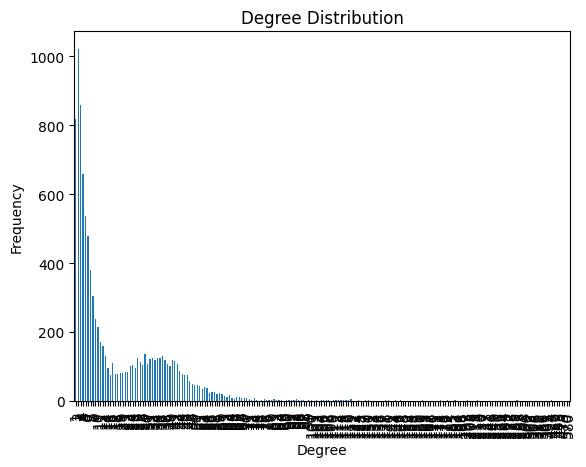

In [6]:
import matplotlib.pyplot as plt

degree_sequence = [d for n, d in B_sampled.degree()]
degree_count = pd.Series(degree_sequence).value_counts().sort_index()
plt.figure()
degree_count.plot(kind='bar')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [7]:
average_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Degree: {average_degree}")

Average Degree: 19.582884558895525


In [8]:
density = nx.density(B_sampled)
print(f"Density: {density}")


Density: 0.0019176346023203608


In [9]:
clustering_coefficient = nx.average_clustering(B_sampled)
print(f"Clustering Coefficient: {clustering_coefficient}")

Clustering Coefficient: 0.0


In [10]:
num_connected_components = nx.number_connected_components(B_sampled)
print(f"Number of Connected Components: {num_connected_components}")

Number of Connected Components: 1


In [11]:
assortativity = nx.degree_assortativity_coefficient(B_sampled)
print(f"Assortativity: {assortativity}")

Assortativity: -0.08180313560668638


In [12]:

local_clustering = nx.clustering(B_sampled)
local_clustering_avg = sum(local_clustering.values()) / len(local_clustering)
print(f"Average Local Clustering Coefficient: {local_clustering_avg}")

Average Local Clustering Coefficient: 0.0


In [13]:
import networkx as nx
import pickle

def centrality_measures(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    
    # Save the centrality measures to files
    with open('degree_centrality.pkl', 'wb') as f:
        pickle.dump(degree_centrality, f)
        
    with open('betweenness_centrality.pkl', 'wb') as f:
        pickle.dump(betweenness_centrality, f)
        
    with open('closeness_centrality.pkl', 'wb') as f:
        pickle.dump(closeness_centrality, f)


centrality_measures(B_sampled)


Degree Centrality - Mean: 0.0019176346023200468, Median: 0.000881316098707403, Max: 0.05679592636114375, Min: 9.792401096748923e-05
Betweenness Centrality - Mean: 0.0002574216689521402, Median: 1.2738740901145195e-05, Max: 0.040972650037435526, Min: 0.0
Closeness Centrality - Mean: 0.2786519051234667, Median: 0.2694103680253265, Max: 0.3727687534221573, Min: 0.17770817019055077


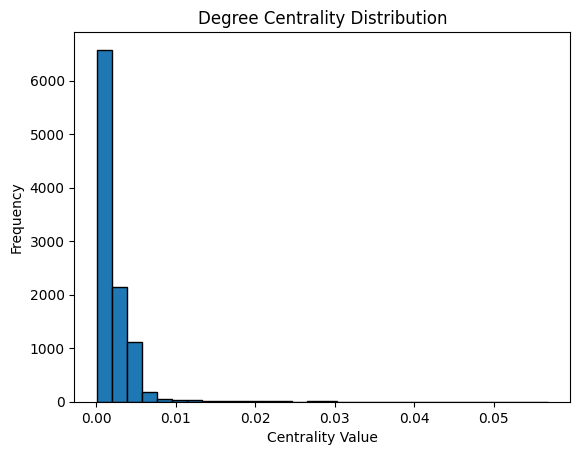

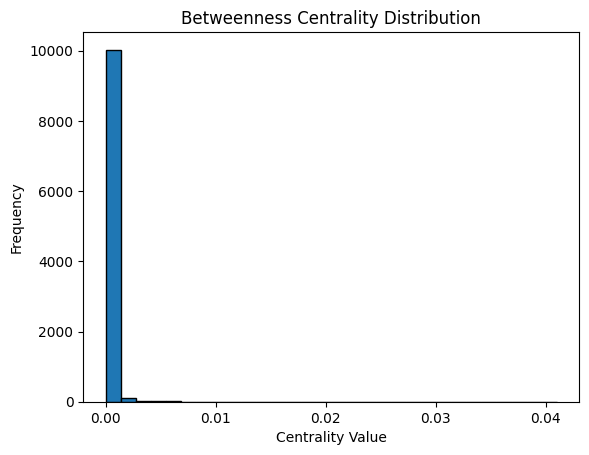

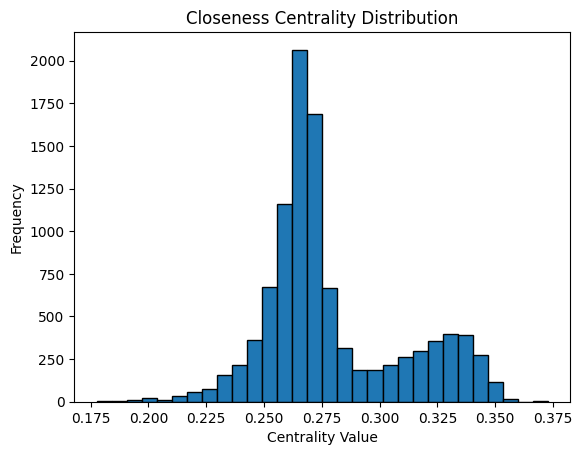

In [14]:
def load_centrality_measures():
    with open('degree_centrality.pkl', 'rb') as f:
        degree_centrality = pickle.load(f)
        
    with open('betweenness_centrality.pkl', 'rb') as f:
        betweenness_centrality = pickle.load(f)
        
    with open('closeness_centrality.pkl', 'rb') as f:
        closeness_centrality = pickle.load(f)
        
    return degree_centrality, betweenness_centrality, closeness_centrality

# Load the centrality measures
degree_centrality, betweenness_centrality, closeness_centrality = load_centrality_measures()

# Convert the centrality measures to lists for easier statistical analysis
degree_values = list(degree_centrality.values())
betweenness_values = list(betweenness_centrality.values())
closeness_values = list(closeness_centrality.values())

# Calculate statistics
def calculate_statistics(values):
    mean_value = sum(values) / len(values)
    median_value = sorted(values)[len(values) // 2]
    max_value = max(values)
    min_value = min(values)
    return mean_value, median_value, max_value, min_value

degree_stats = calculate_statistics(degree_values)
betweenness_stats = calculate_statistics(betweenness_values)
closeness_stats = calculate_statistics(closeness_values)

# Display statistics
print(f'Degree Centrality - Mean: {degree_stats[0]}, Median: {degree_stats[1]}, Max: {degree_stats[2]}, Min: {degree_stats[3]}')
print(f'Betweenness Centrality - Mean: {betweenness_stats[0]}, Median: {betweenness_stats[1]}, Max: {betweenness_stats[2]}, Min: {betweenness_stats[3]}')
print(f'Closeness Centrality - Mean: {closeness_stats[0]}, Median: {closeness_stats[1]}, Max: {closeness_stats[2]}, Min: {closeness_stats[3]}')

# Plot distributions
def plot_distribution(values, title):
    plt.figure()
    plt.hist(values, bins=30, edgecolor='black')
    plt.title(title)
    plt.xlabel('Centrality Value')
    plt.ylabel('Frequency')
    plt.show()

plot_distribution(degree_values, 'Degree Centrality Distribution')
plot_distribution(betweenness_values, 'Betweenness Centrality Distribution')
plot_distribution(closeness_values, 'Closeness Centrality Distribution')

####  BIPARTITE METRIcS

In [8]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite


# Separate the nodes into the two bipartite sets
user_nodes = {n for n, d in B_sampled.nodes(data=True) if d['bipartite'] == 0}
book_nodes = {n for n, d in B_sampled.nodes(data=True) if d['bipartite'] == 1}

# Degree Distribution
avg_degree_users = np.mean([d for n, d in B_sampled.degree(user_nodes)])
avg_degree_books = np.mean([d for n, d in B_sampled.degree(book_nodes)])

# Bipartite Density
bipartite_density = bipartite.density(B_sampled, user_nodes)

# User-User Projection
user_user_proj = bipartite.weighted_projected_graph(B_sampled, user_nodes)

# Book-Book Projection
book_book_proj = bipartite.weighted_projected_graph(B_sampled, book_nodes)

# Print results
print(f'Average Degree (User Nodes): {avg_degree_users}')
print(f'Average Degree (Book Nodes): {avg_degree_books}')
print(f'Bipartite Density: {bipartite_density}')
# Print sample of edges
print('User-User Projection (first 5 edges):')
for edge in list(user_user_proj.edges(data=True))[:5]:
    print(edge)

print('Book-Book Projection (first 5 edges):')
for edge in list(book_book_proj.edges(data=True))[:5]:
    print(edge)


Average Degree (User Nodes): 21.920210434020166
Average Degree (Book Nodes): 12.764871074802144
Bipartite Density: 0.002798086601228002
User-User Projection (first 5 edges):
(49156, 40971, {'weight': 2})
(49156, 24590, {'weight': 3})
(49156, 12306, {'weight': 5})
(49156, 24597, {'weight': 2})
(49156, 36885, {'weight': 4})
Book-Book Projection (first 5 edges):
(1, 2, {'weight': 150})
(1, 3, {'weight': 95})
(1, 4, {'weight': 116})
(1, 5, {'weight': 68})
(1, 6, {'weight': 67})
